In [723]:
import numpy as np
import tensorflow as tf
import sys
import string
import json

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

## Prepare data

In [724]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [725]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

In [726]:
# the loaded samples has three type of labels -1,0,1, in which -1 indicates neutral sentiment.
# We exclude samples with neutral sentiment.
def exclude_neutral_sample(samples:dict):
    ssamples = {}
    for k, v in samples.items():
        if v[3][-1] != -1:
            ssamples[k] = v
    return ssamples
        
train_b = exclude_neutral_sample(sentiment_binary_train)
test_b = exclude_neutral_sample(sentiment_binary_test)

print("After filtering: # of training samples and # of test samples")
print("# of traing samples: ", len(train_b))
print("# of test samples: ", len(test_b))

After filtering: # of training samples and # of test samples
# of traing samples:  6920
# of test samples:  1821


In [727]:
def get_comment(wordidx, idx2word:dict):
    wordlist = []
    for idx in wordidx:
        if idx != -1:
            token = idx2word[idx]
            if token not in string.punctuation:
                wordlist.append(token)
    return wordlist

In [728]:
def get_comments_samples(samples:dict, idx2word:dict):
    comments = []
    targets = []
    for _, v in samples.items():
        if v[3][-1] != -1:
            comment = " ".join(get_comment(v[0], idx2word))
            label = v[3][-1]
            comments.append(comment)
            targets.append(label) 
    return comments, targets

In [729]:
idx2word = {v:k for k, v in word2idx.items()}
train_comments_o, train_targets = get_comments_samples(train_b, idx2word)
test_comments_o, test_targets = get_comments_samples(test_b, idx2word)

vocabulary_size = len(idx2word)
print('vocabulary_size' , vocabulary_size)

count0 = 0
count1 = 0
count2 = 0
for i in range(len(train_comments_o)):

    if train_targets[i] == 0:
        count0 += 1
    elif train_targets[i] == 1:
        count1 += 1
    else:
        count2 += 1
#     print(i, comments[i], targets[i])
    
print("0", count0)
print("1", count1)
print("-1", count2)

vocabulary_size 18647
0 3310
1 3610
-1 0


In [730]:
print(type(train_comments_o))
print(len(train_comments_o))
print(len(train_targets))
print(len(test_comments_o))
print(len(test_targets))
print(train_comments_o[1])
print(train_targets[1])

<class 'list'>
6920
6920
1821
1821
is n't it a bit early in his career for director barry sonnenfeld to do a homage to himself
0


## Preprocessing data

### Define preprocessing data function

In [731]:
def remove_punctuation(samples):
    filtered_samples = []
    for i in samples:
        filtered_samples.append(i.translate(str.maketrans('', '', string.punctuation)))
    return filtered_samples

In [732]:
# test
remove_punctuation(["Today's so beautiful!"])

['Todays so beautiful']

In [733]:
def tokenize(samples):
    tokenized_samples = []
    for s in samples:
        tokens = word_tokenize(s)
        tokenized_samples.append(tokens)
    return tokenized_samples

In [734]:
# test
tokenize(['Todays so beautiful'])

[['Todays', 'so', 'beautiful']]

In [735]:
stopWords = set(stopwords.words('english'))
print(stopWords)

{'at', 'how', 'hasn', 'each', 's', 'wouldn', 'those', 'from', 'weren', 'not', 'whom', 'if', 're', 'we', 'by', 'into', "couldn't", 'it', 'ma', 'than', "you'll", 'very', 'any', 'was', 'is', 'be', 'won', 'had', 'hadn', "shan't", 'you', 'hers', 'but', 'off', 'aren', 'her', 'your', 'other', 'on', 'down', 'most', 'its', 'should', 'shouldn', 'which', 'now', 'ours', "hadn't", 'only', 'mustn', 'in', "you've", 'before', "weren't", 'further', 'below', 'did', 'needn', 'who', 'don', 'once', 'some', 'being', 'does', 'too', 'herself', 'about', "don't", 'my', 'are', 'during', 'few', 'an', 'do', 'couldn', "didn't", 'over', "won't", 'themselves', 'the', 'why', 'a', 'same', 'all', 'own', 'with', 'under', 'myself', 'he', 'because', 'again', 'himself', 'these', "mightn't", 'that', 'am', 'through', 'll', 'so', 've', 'doesn', "you're", 'doing', 'between', "mustn't", 'when', 'ourselves', 'been', 'of', 'our', 'them', 'their', 'while', 'as', 'can', 'where', 'such', 'yourself', 'haven', "wasn't", 'they', "needn'

In [736]:
stopWords_revised = set(('at', 'how', 'each', 's', 'those', 'from','whom', 'if', 're', 'we', 'by','into', 'it', 'ma', 'than', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
             'which', 'now', 'ours', 'in', "you've", 'before', 'further', 'below', 'did',  'who', 'once', 'some', 'being', 
             'does', 'too', 'herself', 'about', 'my', 'are', 'during', 'few', 'an', 'do', 'over',  'themselves', 'the', 'why', 'a', 'same', 'all', 
             'own', 'with', 'under', 'myself', 'he', 'because', 'again', 'himself', 'these', 'that', 'am', 'through', 'll', 'so', 've', "you're", 'doing', 'between', 
             'when', 'ourselves', 'been', 'of', 'our', 'them', 'their', 'while', 'as', 'can', 'where', 'such', 'yourself', 'haven', 'they', 'theirs', 'm', 'both', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 'more', 
                'd', 'o', 'what', 'having', 't', 'this', 'after', 'no', 'then', 'above', 'out', 'nor', "should've", 'his', 
               "you'd", "she's", 'and', 'shan', 'until', 'here', 'for', 'just', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [737]:
stopWords_revised_2 = set(('at', 'each', 's', 'those', 'from', 'if', 're', 'we', 'by','into', 'it', 'ma', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
              'now', 'ours', 'in', "you've", 'below', 'did', 'being', 
             'does', 'herself', 'about', 'my', 'are', 'an', 'do', 'themselves', 'the',  'a',  
             'own', 'myself', 'he',  'himself', 'these', 'that', 'am', 'll', 'so', 've', "you're", 'doing', 
            'ourselves', 'been', 'of', 'our', 'them', 'their', 'can', 'yourself', 'they', 'theirs', 'm', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 
                'd', 'o', 'having', 't', 'this', 'after', 'then', 'out', "should've", 'his', 
               "you'd", "she's", 'shan',  'here', 'for', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [738]:
def remove_stopwords(samples):
    filtered_samples = []
    for s in samples:
        filstered_tokens = []
        for w in s:
            if w not in stopWords_revised_2:
                filstered_tokens.append(w)
        filtered_samples.append(filstered_tokens)
    return filtered_samples    

In [739]:
# test
remove_stopwords([['Todays', 'so', 'not', 'beautiful']])

[['Todays', 'not', 'beautiful']]

### Start preprocessing data

* Remove punctation
* Remove stopwords

**Orginal Data**

In [740]:
for i in range(100):
    print(i, ": ", train_comments_o[i])

0 :  a bittersweet film simple in form but rich with human events
1 :  is n't it a bit early in his career for director barry sonnenfeld to do a homage to himself
2 :  like its bizarre heroine it irrigates our souls
3 :  this is the kind of movie that gets a quick release before real contenders arrive in september
4 :  what makes it worth watching is quaid 's performance
5 :  this long and relentlessly saccharine film is a clear case of preaching to the converted
6 :  this comic gem is as delightful as it is derivative
7 :  all of it works smoothly under the direction of spielberg who does a convincing impersonation here of a director enjoying himself immensely
8 :  the story has little wit and no surprises
9 :  it 's stylishly directed with verve ...
10 :  distinctly sub-par ... more likely to drown a viewer in boredom than to send any shivers down his spine
11 :  predecessors the mummy and the mummy returns stand as intellectual masterpieces next to the scorpion king
12 :  scarcely w

**Perserve n't**

In [741]:
train_comments_1 = []
for comment in train_comments_o:
    new_str = comment.replace("n't", 'not')
    train_comments_1.append(new_str)
    
test_comments_1 = []
for comment in test_comments_o:
    new_str = comment.replace("n't", 'not')
    test_comments_1.append(new_str)

In [742]:
for i in range(100):
    print(i, ": ", train_comments_1[i])

0 :  a bittersweet film simple in form but rich with human events
1 :  is not it a bit early in his career for director barry sonnenfeld to do a homage to himself
2 :  like its bizarre heroine it irrigates our souls
3 :  this is the kind of movie that gets a quick release before real contenders arrive in september
4 :  what makes it worth watching is quaid 's performance
5 :  this long and relentlessly saccharine film is a clear case of preaching to the converted
6 :  this comic gem is as delightful as it is derivative
7 :  all of it works smoothly under the direction of spielberg who does a convincing impersonation here of a director enjoying himself immensely
8 :  the story has little wit and no surprises
9 :  it 's stylishly directed with verve ...
10 :  distinctly sub-par ... more likely to drown a viewer in boredom than to send any shivers down his spine
11 :  predecessors the mummy and the mummy returns stand as intellectual masterpieces next to the scorpion king
12 :  scarcely w

**Remove punctuation**

In [743]:
train_comments_punc = remove_punctuation(train_comments_1)
test_comments_punc = remove_punctuation(test_comments_1)
print("punctuation removed")

punctuation removed


In [744]:
for i in range(100):
    print(i, ": ", train_comments_punc[i])

0 :  a bittersweet film simple in form but rich with human events
1 :  is not it a bit early in his career for director barry sonnenfeld to do a homage to himself
2 :  like its bizarre heroine it irrigates our souls
3 :  this is the kind of movie that gets a quick release before real contenders arrive in september
4 :  what makes it worth watching is quaid s performance
5 :  this long and relentlessly saccharine film is a clear case of preaching to the converted
6 :  this comic gem is as delightful as it is derivative
7 :  all of it works smoothly under the direction of spielberg who does a convincing impersonation here of a director enjoying himself immensely
8 :  the story has little wit and no surprises
9 :  it s stylishly directed with verve 
10 :  distinctly subpar  more likely to drown a viewer in boredom than to send any shivers down his spine
11 :  predecessors the mummy and the mummy returns stand as intellectual masterpieces next to the scorpion king
12 :  scarcely worth a me

**Tokenize**

In [745]:
train_comments_tokenized = tokenize(train_comments_punc)
test_comments_tokenized = tokenize(test_comments_punc)
print("tokenized")

tokenized


In [746]:
for i in range(100):
    print(i, ": ", train_comments_tokenized[i])

0 :  ['a', 'bittersweet', 'film', 'simple', 'in', 'form', 'but', 'rich', 'with', 'human', 'events']
1 :  ['is', 'not', 'it', 'a', 'bit', 'early', 'in', 'his', 'career', 'for', 'director', 'barry', 'sonnenfeld', 'to', 'do', 'a', 'homage', 'to', 'himself']
2 :  ['like', 'its', 'bizarre', 'heroine', 'it', 'irrigates', 'our', 'souls']
3 :  ['this', 'is', 'the', 'kind', 'of', 'movie', 'that', 'gets', 'a', 'quick', 'release', 'before', 'real', 'contenders', 'arrive', 'in', 'september']
4 :  ['what', 'makes', 'it', 'worth', 'watching', 'is', 'quaid', 's', 'performance']
5 :  ['this', 'long', 'and', 'relentlessly', 'saccharine', 'film', 'is', 'a', 'clear', 'case', 'of', 'preaching', 'to', 'the', 'converted']
6 :  ['this', 'comic', 'gem', 'is', 'as', 'delightful', 'as', 'it', 'is', 'derivative']
7 :  ['all', 'of', 'it', 'works', 'smoothly', 'under', 'the', 'direction', 'of', 'spielberg', 'who', 'does', 'a', 'convincing', 'impersonation', 'here', 'of', 'a', 'director', 'enjoying', 'himself', 'im

**Remove stopwords**

In [747]:
train_comments_stopwords = remove_stopwords(train_comments_tokenized)
test_comments_stopwords = remove_stopwords(test_comments_tokenized)
print("stopwords removed")

stopwords removed


In [748]:
for i in range(100):
    print(i, ": ", train_comments_stopwords[i])

0 :  ['bittersweet', 'film', 'simple', 'form', 'but', 'rich', 'with', 'human', 'events']
1 :  ['not', 'bit', 'early', 'career', 'director', 'barry', 'sonnenfeld', 'homage']
2 :  ['like', 'bizarre', 'heroine', 'irrigates', 'souls']
3 :  ['kind', 'movie', 'gets', 'quick', 'release', 'before', 'real', 'contenders', 'arrive', 'september']
4 :  ['what', 'makes', 'worth', 'watching', 'quaid', 'performance']
5 :  ['long', 'and', 'relentlessly', 'saccharine', 'film', 'clear', 'case', 'preaching', 'converted']
6 :  ['comic', 'gem', 'as', 'delightful', 'as', 'derivative']
7 :  ['all', 'works', 'smoothly', 'under', 'direction', 'spielberg', 'who', 'convincing', 'impersonation', 'director', 'enjoying', 'immensely']
8 :  ['story', 'little', 'wit', 'and', 'no', 'surprises']
9 :  ['stylishly', 'directed', 'with', 'verve']
10 :  ['distinctly', 'subpar', 'more', 'likely', 'drown', 'viewer', 'boredom', 'than', 'send', 'any', 'shivers', 'spine']
11 :  ['predecessors', 'mummy', 'and', 'mummy', 'returns', 

In [749]:
###

In [750]:
def combine(tokenized_comments):
    text = []
    for comment in tokenized_comments:
        text += comment
    return text

all_words = combine(train_comments_stopwords) + combine(test_comments_stopwords)
print(all_words)
# all_text1 = ' '.join(train_comments_stopwords)
# all_text2 = ' '.join(test_comments_stopwords)
# words1 = all_text1.split()
# words2 = all_text2.split()
# all_words = words1 + words2

['bittersweet', 'film', 'simple', 'form', 'but', 'rich', 'with', 'human', 'events', 'not', 'bit', 'early', 'career', 'director', 'barry', 'sonnenfeld', 'homage', 'like', 'bizarre', 'heroine', 'irrigates', 'souls', 'kind', 'movie', 'gets', 'quick', 'release', 'before', 'real', 'contenders', 'arrive', 'september', 'what', 'makes', 'worth', 'watching', 'quaid', 'performance', 'long', 'and', 'relentlessly', 'saccharine', 'film', 'clear', 'case', 'preaching', 'converted', 'comic', 'gem', 'as', 'delightful', 'as', 'derivative', 'all', 'works', 'smoothly', 'under', 'direction', 'spielberg', 'who', 'convincing', 'impersonation', 'director', 'enjoying', 'immensely', 'story', 'little', 'wit', 'and', 'no', 'surprises', 'stylishly', 'directed', 'with', 'verve', 'distinctly', 'subpar', 'more', 'likely', 'drown', 'viewer', 'boredom', 'than', 'send', 'any', 'shivers', 'spine', 'predecessors', 'mummy', 'and', 'mummy', 'returns', 'stand', 'as', 'intellectual', 'masterpieces', 'next', 'scorpion', 'king'

In [751]:
# Create your dictionary that maps vocab words to integers here
from collections import Counter
counts = Counter(all_words)
print(type(counts))

vocab = sorted(counts, key=counts.get, reverse=True)

# Note that index start from 1
vocab_to_int = {word:i for i, word in enumerate(vocab, 1)}

<class 'collections.Counter'>


In [753]:
print("type of vocab", type(vocab))
print('total # of words: ', len(vocab_to_int))
print("first word:", vocab[0])
print("last word:", vocab[-1])
print("first word index:", vocab_to_int[vocab[0]])
print("last word index", vocab_to_int[vocab[-1]])

type of vocab <class 'list'>
total # of words:  16547
first word: and
last word: jon
first word index: 1
last word index 16547


In [754]:
index2word = {idx:word for word, idx in vocab_to_int.items()}

In [755]:
def convert_to_int(reviews, vocab_to_int):
    # Convert the reviews to integers, same shape as reviews list, but with integers
    print('# of reviews before index: ', len(reviews))
    reviews_ints = []
    for review in reviews:
        reviews_ints.append([vocab_to_int[word] for word in review])

    print('# of reviews after index: ', len(reviews_ints))
    return reviews_ints

In [756]:
x_train = convert_to_int(train_comments_stopwords, vocab_to_int)

# of reviews before index:  6920
# of reviews after index:  6920


In [757]:
# test
print(x_train[7])
print(train_comments_o[7])
text = [index2word[idx] for idx in x_train[7]]
print(text)

[12, 147, 5567, 246, 174, 665, 17, 805, 5872, 34, 3207, 2745]
all of it works smoothly under the direction of spielberg who does a convincing impersonation here of a director enjoying himself immensely
['all', 'works', 'smoothly', 'under', 'direction', 'spielberg', 'who', 'convincing', 'impersonation', 'director', 'enjoying', 'immensely']


In [758]:
x_test = convert_to_int(test_comments_stopwords, vocab_to_int)

# of reviews before index:  1821
# of reviews after index:  1821


In [759]:
from collections import Counter

# Create length to frequency map
x_train_lens_map = Counter([len(x) for x in x_train])
x_train_lens = [len(x) for x in x_train]
print("Zero-length reviews: {}".format(x_train_lens_map[0]))
print("Maximum train example length: {}".format(max(x_train_lens_map)))

Zero-length reviews: 2
Maximum train example length: 36


In [760]:
type(list(x_train_lens_map.keys()))

list

In [761]:
# Create length to frequency map
x_test_lens_map = Counter([len(x) for x in x_test])
x_test_lens = [len(x) for x in x_test]
print("Zero-length reviews: {}".format(x_test_lens_map[0]))
print("Maximum test example length: {}".format(max(x_test_lens_map)))


ave_len = 0
for i in x_train:
    ave_len += len(i) 
ave_len = ave_len / len(x_train)
print(ave_len)

ave_len = 0
for i in x_test:
#     print(i)
    ave_len += len(i)  
ave_len = ave_len / len(x_test)
print(ave_len)


Zero-length reviews: 0
Maximum test example length: 31
11.324566473988439
11.314662273476111


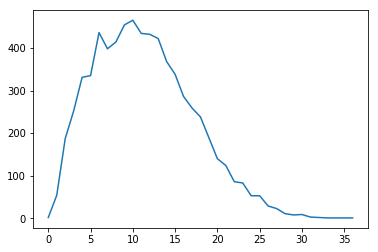

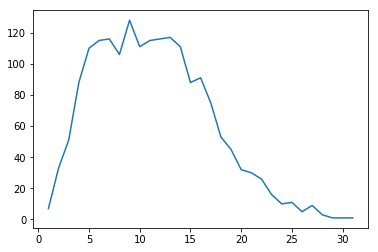

In [762]:
import matplotlib.pyplot as plt
plt.plot(list(x_train_lens_map.keys()), list(x_train_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

plt.plot(list(x_test_lens_map.keys()), list(x_test_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

In [763]:
def left_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    print(features.shape)
    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # left padding
        features[i, -len(row):] = np.array(row)[:seq_len]
        
        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths


In [764]:
def right_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    print(features.shape)
    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # right padding
        features[i, :len(row)] = np.array(row)[:seq_len]

        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths

In [789]:
## test

sample1 = [4,6,7,2,3,5,7,8,1]
sample2 = [1,2,3,4,6,7,2,3,5,7]
sample3 = [1,2,3,4,6,7,2,3,26,1, 11, 12]
sample4 = [8,7,3]
samples = []
samples.append(sample1)
samples.append(sample2)
samples.append(sample3)
samples.append(sample4)
features_, lengths_ = left_padding(samples, 10)

print(features_)
print(lengths_)

(4, 10)
[[ 0  4  6  7  2  3  5  7  8  1]
 [ 1  2  3  4  6  7  2  3  5  7]
 [ 1  2  3  4  6  7  2  3 26  1]
 [ 0  0  0  0  0  0  0  8  7  3]]
[9, 10, 10, 3]


In [790]:
x_train_f = []
y_train_f = []
for idx in range(len(x_train)):
    if len(x_train[idx]) != 0:
        x_train_f.append(x_train[idx])
        y_train_f.append(train_targets[idx])

x_test_f = []
y_test_f = []
for idx in range(len(x_test)):
    if len(x_test[idx]) != 0:
        x_test_f.append(x_test[idx])
        y_test_f.append(test_targets[idx])

In [791]:
seq_len = 36
x_train_p, x_train_len = left_padding(x_train_f, seq_len)
x_test_p, x_test_len = left_padding(x_test_f, seq_len)

(6918, 36)
(1821, 36)


In [792]:
print(x_train_p[:5,:seq_len])
print(x_train_len[:5])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  1420     5   415   820     6   426     4   138   484]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     3   192  1404   643    34  1508 10892  1528]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0    10  1101  2608 11092  2144]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0    99     7   152  1538  1381   141    96  5105  2633  5064]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   

** Resplit training data **

In [793]:
x_train_ = np.append(x_train_p, x_test_p[:1086], axis=0)
x_test_ = x_test_p[1086:]

y_train_ = np.array(np.append(y_train_f, y_test_f[:1086], axis=0))
y_test_ = np.array(y_test_f[1086:])

x_train_len_ = np.append(x_train_len, x_test_len[:1086], axis=0)
x_test_len_ = x_test_len[1086:]

print(len(x_train_))
print(len(x_test_))
print(len(y_train_))
print(len(y_test_))
print(len(x_train_len_))
print(len(x_test_len_))

8004
735
8004
735
8004
735


In [794]:
print(x_train_.shape)
print(x_test_.shape)
print(y_train_.shape)
print(y_test_.shape)
# print(x_train_len_.shape)
# print(x_test_len_.shape)

(8004, 36)
(735, 36)
(8004,)
(735,)


## Model

In [775]:
def get_batches(x, y, lengths, batch_size):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(x) == len(y)
    n_batches = len(x)//batch_size

    # Only get full batches
    features, labels = x[:n_batches*batch_size], y[:n_batches*batch_size]
    
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
#         print("start_i", start_i)
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i], lengths[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

In [776]:
def get_batches_with_shuffle(features, labels, lengths, batch_size):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    
    sample_indices = list(range(len(features)))
    np.random.shuffle(sample_indices)
    print(type(sample_indices))
    indices_batches = []
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        indices_batch = sample_indices[start_i:end_i]
        indices_batches.append(indices_batch)
        
    output_batches = []
    for index_batch in indices_batches:
        x = [features[idx] for idx in index_batch]
        y = [labels[idx] for idx in index_batch]
        seqlen = [lengths[idx] for idx in index_batch]
        batch = [x, y, seqlen]
        output_batches.append(batch)
        
    return output_batches

In [777]:
print(len(x_train_))
print(len(y_train_))
print(len(x_train_len_))

8004
8004
8004


In [778]:
# Test get_batches
batch_outputs_ = get_batches_with_shuffle(x_train_, y_train_, x_train_len_, 100)
one_batch = batch_outputs_[0]
x_train_batch_1 = one_batch[0]
y_train_batch_1 = one_batch[1]
x_train_len_batch_1 = one_batch[2]

<class 'list'>


In [779]:
print(len(batch_outputs_))
print(len(x_train_batch_1))
print(len(y_train_batch_1))
print(len(x_train_len_batch_1))

print(x_train_batch_1[5].shape)
print(y_train_batch_1[5].shape)

print(x_train_batch_1[5])
print(y_train_batch_1[5])
print(x_train_len_batch_1[5])



81
100
100
100
(36,)
()
[ 134 2867  163    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
0
3


In [780]:
def get_batches_generator(x, y, seq_len, batch_size=100):
    
    n_batches = len(x)//batch_size
    
    # Only get full batches
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [781]:
# with graph.as_default():
    
#     def build_cell(lstm_units, keep_prob):
#         cell = tf.contrib.rnn.BasicLSTMCell(lstm_units)
#         drop = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = keep_prob)
#         return drop

In [803]:
tf.reset_default_graph()

### Run Bidirectional LSTM Model

In [808]:
def BiLSTM_RNN_Model(vocab_size, learning_rate = 0.001, embedding_dim = 300, 
                   lstm_size = 256, num_lstm_layer = 1, batch_size = 200, keep_probability=0.8, epochs=400):
    
    graph = tf.Graph()
    with graph.as_default():

        # input placeholders
        inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
        labels = tf.placeholder(tf.float32, shape=[None, None], name='labels')
    #     seq_len = tf.placeholder(tf.int32, shape=[None], name='seq_len')
        keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

        # embedding layer
        embedding = tf.Variable(tf.random_uniform((vocab_size, embedding_dim), -1, 1), name = 'embedding')
        embed = tf.nn.embedding_lookup(embedding, inputs)


        # LSTM layer
        with tf.name_scope("biLSTM"):
            with tf.variable_scope("forward"):
                fw_cell = tf.nn.rnn_cell.LSTMCell(num_units=lstm_size)
#                 fw_cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
                fw_cell = tf.contrib.rnn.DropoutWrapper(fw_cell, output_keep_prob = keep_prob)
            with tf.variable_scope("backward"):
                bw_cell = tf.nn.rnn_cell.LSTMCell(num_units=lstm_size)
#                 bw_cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
                bw_cell = tf.contrib.rnn.DropoutWrapper(bw_cell, output_keep_prob = keep_prob)

        initial_state_fw = fw_cell.zero_state(batch_size, tf.float32)
        initial_state_bw = bw_cell.zero_state(batch_size, tf.float32)

        outputs, final_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=fw_cell, cell_bw=bw_cell,
                                                    inputs=embed,
    #                                                 sequence_length=seq_len,
                                                    initial_state_fw=initial_state_fw,
                                                    initial_state_bw=initial_state_bw,
                                                    scope="biLSTM")


        outputs = tf.concat(axis = 2, values = outputs)

        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.nn.sigmoid)

    #     cost = tf.losses.mean_squared_error(labels, predictions)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=predictions)
        entroy = tf.reduce_mean(cost)
        

#         # Optimizer for training, using gradient clipping to control exploding gradients
#         tvars = tf.trainable_variables()
#         # grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
#         grads = tf.gradients(entroy, tvars)
#         clip_grads, _ = tf.clip_by_global_norm(grads, 5.0)
#         train_op = tf.train.AdamOptimizer(learning_rate)
#         optimizer = train_op.apply_gradients(zip(clip_grads, tvars))
    
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(entroy)

        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), tf.cast(tf.round(labels), tf.int32))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    with graph.as_default():
        saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        
        sess.run(tf.global_variables_initializer())
        iteration = 1
        
        for e in range(epochs):

    #         state = sess.run(initial_state)
            state_fw = sess.run(initial_state_fw)
            state_bw = sess.run(initial_state_bw)

            for batch_features, batch_labels, batch_len in get_batches(x_train_, y_train_, x_train_len_, batch_size):
    #             batch_len = np.array(batch_len)
    #                 print(batch_features.shape)
    #                 print(batch_labels.shape)
    #                 print(batch_len.shape)

                feed = {inputs: batch_features,
                        labels: batch_labels[:, None],   # change ths shape of y to [batch_size, 1]
    #                     seq_len: batch_len,
                        keep_prob: keep_probability,
                        initial_state_fw: state_fw,
                        initial_state_bw: state_bw}
                loss, state, _ = sess.run([entroy, final_state, optimizer], feed_dict=feed)
                state_fw, state_bw = state

                if iteration%5==0:
    #                   print(loss)
                        print("Epoch: {}/{}".format(e, epochs),
                              "Iteration: {}".format(iteration),
                              "Train loss: {:.3f}".format(loss))

                if iteration%25==0:
                    val_acc = []
                    val_state_fw = sess.run(fw_cell.zero_state(batch_size, tf.float32))
                    val_state_bw = sess.run(bw_cell.zero_state(batch_size, tf.float32))

                    for x, y, batch_len in get_batches(x_test_, y_test_, x_test_len_, batch_size):
                        feed = {inputs: x,
                                labels: y[:, None],
    #                             seq_len: batch_len,
                                keep_prob: 1,  # note the keep probablity is 1 here
                                initial_state_fw: val_state_fw,
                                initial_state_fw: val_state_bw}
                        batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                        val_acc.append(batch_acc)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1

        saver.save(sess, "checkpoints/sentiment.ckpt")

In [809]:
vocab_size = len(vocab_to_int) + 1
num_lstm_layer = 1

epochs = 40

batch_sizes = [400]

embedding_dims = [256]
lstm_sizes = [128, 256]
learning_rates = [0.001, 0.005]
keep_probabilities = [0.7, 0.8]

# embedding_dims = [200, 300, 400]
# lstm_sizes = [128, 256]
# learning_rates = [0.001, 0.0005, 0.0001]
# keep_probabilities = [0.6, 0.8, 1.0]

# Grid Search
for batch_size in batch_sizes:
    for embedding_dim in embedding_dims:
        for lstm_size in lstm_sizes:
            for learning_rate in learning_rates:
                for keep_probability in keep_probabilities:
                    print("---------------------------------------------")
                    print("Start with new set of hyperparameters:")
                    print("batch_size", batch_size)
                    print("embedding_dim", embedding_dim)
                    print("lstm_size", lstm_size)
                    print("learning_rate", learning_rate)
                    print("keep_probability", keep_probability)
                    BiLSTM_RNN_Model(vocab_size, learning_rate, embedding_dim, lstm_size, num_lstm_layer, 
                       batch_size, keep_probability, epochs)

---------------------------------------------
Start with new set of hyperparameters:
batch_size 400
embedding_dim 256
lstm_size 128
learning_rate 0.001
keep_probability 0.7
Epoch: 0/40 Iteration: 5 Train loss: 0.694
Epoch: 0/40 Iteration: 10 Train loss: 0.694
Epoch: 0/40 Iteration: 15 Train loss: 0.692
Epoch: 0/40 Iteration: 20 Train loss: 0.685
Epoch: 1/40 Iteration: 25 Train loss: 0.676
Val acc: 0.642
Epoch: 1/40 Iteration: 30 Train loss: 0.691
Epoch: 1/40 Iteration: 35 Train loss: 0.677
Epoch: 1/40 Iteration: 40 Train loss: 0.655
Epoch: 2/40 Iteration: 45 Train loss: 0.638
Epoch: 2/40 Iteration: 50 Train loss: 0.654
Val acc: 0.707
Epoch: 2/40 Iteration: 55 Train loss: 0.638
Epoch: 2/40 Iteration: 60 Train loss: 0.615
Epoch: 3/40 Iteration: 65 Train loss: 0.603
Epoch: 3/40 Iteration: 70 Train loss: 0.611
Epoch: 3/40 Iteration: 75 Train loss: 0.603
Val acc: 0.738
Epoch: 3/40 Iteration: 80 Train loss: 0.574
Epoch: 4/40 Iteration: 85 Train loss: 0.575
Epoch: 4/40 Iteration: 90 Train los

Epoch: 0/40 Iteration: 15 Train loss: 0.691
Epoch: 0/40 Iteration: 20 Train loss: 0.685
Epoch: 1/40 Iteration: 25 Train loss: 0.671
Val acc: 0.630
Epoch: 1/40 Iteration: 30 Train loss: 0.693
Epoch: 1/40 Iteration: 35 Train loss: 0.671
Epoch: 1/40 Iteration: 40 Train loss: 0.661
Epoch: 2/40 Iteration: 45 Train loss: 0.632
Epoch: 2/40 Iteration: 50 Train loss: 0.645
Val acc: 0.695
Epoch: 2/40 Iteration: 55 Train loss: 0.632
Epoch: 2/40 Iteration: 60 Train loss: 0.619
Epoch: 3/40 Iteration: 65 Train loss: 0.589
Epoch: 3/40 Iteration: 70 Train loss: 0.606
Epoch: 3/40 Iteration: 75 Train loss: 0.591
Val acc: 0.733
Epoch: 3/40 Iteration: 80 Train loss: 0.578
Epoch: 4/40 Iteration: 85 Train loss: 0.556
Epoch: 4/40 Iteration: 90 Train loss: 0.579
Epoch: 4/40 Iteration: 95 Train loss: 0.570
Epoch: 4/40 Iteration: 100 Train loss: 0.556
Val acc: 0.757
Epoch: 5/40 Iteration: 105 Train loss: 0.534
Epoch: 5/40 Iteration: 110 Train loss: 0.562
Epoch: 5/40 Iteration: 115 Train loss: 0.564
Epoch: 5/40 

Epoch: 2/40 Iteration: 45 Train loss: 0.557
Epoch: 2/40 Iteration: 50 Train loss: 0.557
Val acc: 0.733
Epoch: 2/40 Iteration: 55 Train loss: 0.543
Epoch: 2/40 Iteration: 60 Train loss: 0.542
Epoch: 3/40 Iteration: 65 Train loss: 0.528
Epoch: 3/40 Iteration: 70 Train loss: 0.534
Epoch: 3/40 Iteration: 75 Train loss: 0.532
Val acc: 0.738
Epoch: 3/40 Iteration: 80 Train loss: 0.527
Epoch: 4/40 Iteration: 85 Train loss: 0.516
Epoch: 4/40 Iteration: 90 Train loss: 0.526
Epoch: 4/40 Iteration: 95 Train loss: 0.526
Epoch: 4/40 Iteration: 100 Train loss: 0.530
Val acc: 0.740
Epoch: 5/40 Iteration: 105 Train loss: 0.510
Epoch: 5/40 Iteration: 110 Train loss: 0.519
Epoch: 5/40 Iteration: 115 Train loss: 0.525
Epoch: 5/40 Iteration: 120 Train loss: 0.515
Epoch: 6/40 Iteration: 125 Train loss: 0.506
Val acc: 0.765
Epoch: 6/40 Iteration: 130 Train loss: 0.518
Epoch: 6/40 Iteration: 135 Train loss: 0.522
Epoch: 6/40 Iteration: 140 Train loss: 0.512
Epoch: 7/40 Iteration: 145 Train loss: 0.505
Epoch:

Epoch: 3/40 Iteration: 75 Train loss: 0.532
Val acc: 0.798
Epoch: 3/40 Iteration: 80 Train loss: 0.524
Epoch: 4/40 Iteration: 85 Train loss: 0.516
Epoch: 4/40 Iteration: 90 Train loss: 0.521
Epoch: 4/40 Iteration: 95 Train loss: 0.533
Epoch: 4/40 Iteration: 100 Train loss: 0.519
Val acc: 0.808
Epoch: 5/40 Iteration: 105 Train loss: 0.508
Epoch: 5/40 Iteration: 110 Train loss: 0.518
Epoch: 5/40 Iteration: 115 Train loss: 0.522
Epoch: 5/40 Iteration: 120 Train loss: 0.517
Epoch: 6/40 Iteration: 125 Train loss: 0.510
Val acc: 0.777
Epoch: 6/40 Iteration: 130 Train loss: 0.515
Epoch: 6/40 Iteration: 135 Train loss: 0.522
Epoch: 6/40 Iteration: 140 Train loss: 0.516
Epoch: 7/40 Iteration: 145 Train loss: 0.509
Epoch: 7/40 Iteration: 150 Train loss: 0.520
Val acc: 0.793
Epoch: 7/40 Iteration: 155 Train loss: 0.519
Epoch: 7/40 Iteration: 160 Train loss: 0.519
Epoch: 8/40 Iteration: 165 Train loss: 0.509
Epoch: 8/40 Iteration: 170 Train loss: 0.519
Epoch: 8/40 Iteration: 175 Train loss: 0.522


Val acc: 0.728
Epoch: 5/40 Iteration: 105 Train loss: 0.555
Epoch: 5/40 Iteration: 110 Train loss: 0.590
Epoch: 5/40 Iteration: 115 Train loss: 0.567
Epoch: 5/40 Iteration: 120 Train loss: 0.554
Epoch: 6/40 Iteration: 125 Train loss: 0.537
Val acc: 0.735
Epoch: 6/40 Iteration: 130 Train loss: 0.553
Epoch: 6/40 Iteration: 135 Train loss: 0.547
Epoch: 6/40 Iteration: 140 Train loss: 0.548
Epoch: 7/40 Iteration: 145 Train loss: 0.535
Epoch: 7/40 Iteration: 150 Train loss: 0.545
Val acc: 0.733
Epoch: 7/40 Iteration: 155 Train loss: 0.547
Epoch: 7/40 Iteration: 160 Train loss: 0.539
Epoch: 8/40 Iteration: 165 Train loss: 0.535
Epoch: 8/40 Iteration: 170 Train loss: 0.536
Epoch: 8/40 Iteration: 175 Train loss: 0.542
Val acc: 0.738
Epoch: 8/40 Iteration: 180 Train loss: 0.540
Epoch: 9/40 Iteration: 185 Train loss: 0.524
Epoch: 9/40 Iteration: 190 Train loss: 0.531
Epoch: 9/40 Iteration: 195 Train loss: 0.533
Epoch: 9/40 Iteration: 200 Train loss: 0.536
Val acc: 0.757
Epoch: 10/40 Iteration: 2

Val acc: 0.755
Epoch: 6/40 Iteration: 130 Train loss: 0.551
Epoch: 6/40 Iteration: 135 Train loss: 0.558
Epoch: 6/40 Iteration: 140 Train loss: 0.540
Epoch: 7/40 Iteration: 145 Train loss: 0.532
Epoch: 7/40 Iteration: 150 Train loss: 0.545
Val acc: 0.745
Epoch: 7/40 Iteration: 155 Train loss: 0.552
Epoch: 7/40 Iteration: 160 Train loss: 0.539
Epoch: 8/40 Iteration: 165 Train loss: 0.531
Epoch: 8/40 Iteration: 170 Train loss: 0.543
Epoch: 8/40 Iteration: 175 Train loss: 0.543
Val acc: 0.735
Epoch: 8/40 Iteration: 180 Train loss: 0.539
Epoch: 9/40 Iteration: 185 Train loss: 0.518
Epoch: 9/40 Iteration: 190 Train loss: 0.544
Epoch: 9/40 Iteration: 195 Train loss: 0.538
Epoch: 9/40 Iteration: 200 Train loss: 0.522
Val acc: 0.728
Epoch: 10/40 Iteration: 205 Train loss: 0.517
Epoch: 10/40 Iteration: 210 Train loss: 0.531
Epoch: 10/40 Iteration: 215 Train loss: 0.534
Epoch: 10/40 Iteration: 220 Train loss: 0.519
Epoch: 11/40 Iteration: 225 Train loss: 0.512
Val acc: 0.733
Epoch: 11/40 Iterati

Val acc: 0.770
Epoch: 7/40 Iteration: 155 Train loss: 0.523
Epoch: 7/40 Iteration: 160 Train loss: 0.509
Epoch: 8/40 Iteration: 165 Train loss: 0.502
Epoch: 8/40 Iteration: 170 Train loss: 0.522
Epoch: 8/40 Iteration: 175 Train loss: 0.521
Val acc: 0.775
Epoch: 8/40 Iteration: 180 Train loss: 0.507
Epoch: 9/40 Iteration: 185 Train loss: 0.499
Epoch: 9/40 Iteration: 190 Train loss: 0.519
Epoch: 9/40 Iteration: 195 Train loss: 0.520
Epoch: 9/40 Iteration: 200 Train loss: 0.506
Val acc: 0.793
Epoch: 10/40 Iteration: 205 Train loss: 0.498
Epoch: 10/40 Iteration: 210 Train loss: 0.519
Epoch: 10/40 Iteration: 215 Train loss: 0.518
Epoch: 10/40 Iteration: 220 Train loss: 0.506
Epoch: 11/40 Iteration: 225 Train loss: 0.499
Val acc: 0.788
Epoch: 11/40 Iteration: 230 Train loss: 0.518
Epoch: 11/40 Iteration: 235 Train loss: 0.516
Epoch: 11/40 Iteration: 240 Train loss: 0.503
Epoch: 12/40 Iteration: 245 Train loss: 0.498
Epoch: 12/40 Iteration: 250 Train loss: 0.518
Val acc: 0.780
Epoch: 12/40 It

Val acc: 0.720
Epoch: 8/40 Iteration: 180 Train loss: 0.568
Epoch: 9/40 Iteration: 185 Train loss: 0.538
Epoch: 9/40 Iteration: 190 Train loss: 0.554
Epoch: 9/40 Iteration: 195 Train loss: 0.547
Epoch: 9/40 Iteration: 200 Train loss: 0.550
Val acc: 0.725
Epoch: 10/40 Iteration: 205 Train loss: 0.534
Epoch: 10/40 Iteration: 210 Train loss: 0.533
Epoch: 10/40 Iteration: 215 Train loss: 0.541
Epoch: 10/40 Iteration: 220 Train loss: 0.532
Epoch: 11/40 Iteration: 225 Train loss: 0.517
Val acc: 0.730
Epoch: 11/40 Iteration: 230 Train loss: 0.529
Epoch: 11/40 Iteration: 235 Train loss: 0.538
Epoch: 11/40 Iteration: 240 Train loss: 0.528
Epoch: 12/40 Iteration: 245 Train loss: 0.508
Epoch: 12/40 Iteration: 250 Train loss: 0.523
Val acc: 0.770
Epoch: 12/40 Iteration: 255 Train loss: 0.529
Epoch: 12/40 Iteration: 260 Train loss: 0.521
Epoch: 13/40 Iteration: 265 Train loss: 0.509
Epoch: 13/40 Iteration: 270 Train loss: 0.523
Epoch: 13/40 Iteration: 275 Train loss: 0.527
Val acc: 0.772
Epoch: 13/

### Run LSTM Model

In [806]:
def LSTM_RNN_Model(vocab_size, learning_rate = 0.001, embedding_dim = 300, 
                   lstm_size = 256, num_lstm_layer = 1, batch_size = 200, keep_probability=0.8, epochs=400):

    graph = tf.Graph()
    with graph.as_default():

        # input placeholders
        inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
        labels = tf.placeholder(tf.float32, shape=[None, None], name='labels')
#         seq_len = tf.placeholder(tf.int32, shape=[None], name='seq_len')
        keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

        # embedding layer
        embedding = tf.Variable(tf.random_uniform((vocab_size, embedding_dim), -1, 1), name = 'embedding')
        embed = tf.nn.embedding_lookup(embedding, inputs)


        # LSTM layer
        def build_cell(lstm_units, keep_prob):
            cell = tf.nn.rnn_cell.LSTMCell(num_units=lstm_units)
#             cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_units, activation=tf.nn.relu)
            drop = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = keep_prob)
            return drop

        cell = tf.contrib.rnn.MultiRNNCell([build_cell(lstm_size, keep_prob) for _ in range(num_lstm_layer)])
        initial_state = cell.zero_state(batch_size, tf.float32)

        outputs, final_state = tf.nn.dynamic_rnn(cell, 
                                                 embed, 
#                                                  sequence_length = seq_len,
                                                 initial_state = initial_state)


        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.nn.sigmoid)

    #     cost = tf.losses.mean_squared_error(labels, predictions)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=predictions)
        entroy = tf.reduce_mean(cost)

        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(entroy)

        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), tf.cast(tf.round(labels), tf.int32))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:

        sess.run(tf.global_variables_initializer())
        iteration = 1

        for e in range(epochs):

            state = sess.run(initial_state)

            for batch_features, batch_labels, batch_len in get_batches(x_train_, y_train_, x_train_len_, batch_size):
                batch_len = np.array(batch_len)

                feed = {inputs: batch_features,
                        labels: batch_labels[:, None],   # change ths shape of y to [batch_size, 1]
#                         seq_len: batch_len,
                        keep_prob: keep_probability,
                        initial_state: state}
                loss, state, _ = sess.run([entroy, final_state, optimizer], feed_dict=feed)
            
                if iteration%25==0:
    #                   print(loss)
                        print("Epoch: {}/{}".format(e, epochs),
                              "Iteration: {}".format(iteration),
                              "Train loss: {:.3f}".format(loss))

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(cell.zero_state(batch_size, tf.float32))

                    for x, y, batch_len in get_batches(x_test_, y_test_, x_test_len_, batch_size):
                        feed = {inputs: x,
                                labels: y[:, None],
#                                 seq_len: batch_len,
                                keep_prob: 1,  # note the keep probablity is 1 here
                                initial_state: val_state}
                        batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                        val_acc.append(batch_acc)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1

        saver.save(sess, "checkpoints/sentiment.ckpt")

In [807]:
vocab_size = len(vocab_to_int) + 1
num_lstm_layer = 1

epochs = 30

# batch_size 400
# embedding_dim 300
# lstm_size 128
# learning_rate 0.005
# keep_probability 0.8

batch_sizes = [400]

embedding_dims = [256]
lstm_sizes = [128, 256]
learning_rates = [0.001, 0.005]
keep_probabilities = [0.7, 0.8]

# embedding_dims = [200, 300, 400]
# lstm_sizes = [128, 256]
# learning_rates = [0.001, 0.0005, 0.0001]
# keep_probabilities = [0.6, 0.8, 1.0]

# Grid Search
for batch_size in batch_sizes:
    for embedding_dim in embedding_dims:
        for lstm_size in lstm_sizes:
            for learning_rate in learning_rates:
                for keep_probability in keep_probabilities:
                    print("-------------------------------------------------------------------")
                    print("Start with new set of hyperparameters:")
                    print("batch_size", batch_size)
                    print("embedding_dim", embedding_dim)
                    print("lstm_size", lstm_size)
                    print("learning_rate", learning_rate)
                    print("keep_probability", keep_probability)
                    LSTM_RNN_Model(vocab_size, learning_rate, embedding_dim, lstm_size, num_lstm_layer, 
                       batch_size, keep_probability, epochs)
            

-------------------------------------------------------------------
Start with new set of hyperparameters:
batch_size 400
embedding_dim 256
lstm_size 128
learning_rate 0.001
keep_probability 0.7
Epoch: 1/30 Iteration: 25 Train loss: 0.673
Val acc: 0.630
Epoch: 2/30 Iteration: 50 Train loss: 0.653
Val acc: 0.700
Epoch: 3/30 Iteration: 75 Train loss: 0.610
Val acc: 0.743
Epoch: 4/30 Iteration: 100 Train loss: 0.561
Val acc: 0.772
Epoch: 6/30 Iteration: 125 Train loss: 0.538
Val acc: 0.728
Epoch: 7/30 Iteration: 150 Train loss: 0.558
Val acc: 0.743
Epoch: 8/30 Iteration: 175 Train loss: 0.541
Val acc: 0.752
Epoch: 9/30 Iteration: 200 Train loss: 0.525
Val acc: 0.765
Epoch: 11/30 Iteration: 225 Train loss: 0.523
Val acc: 0.762
Epoch: 12/30 Iteration: 250 Train loss: 0.528
Val acc: 0.780
Epoch: 13/30 Iteration: 275 Train loss: 0.528
Val acc: 0.785
Epoch: 14/30 Iteration: 300 Train loss: 0.510
Val acc: 0.788
Epoch: 16/30 Iteration: 325 Train loss: 0.503
Val acc: 0.790
Epoch: 17/30 Iteration:

Val acc: 0.760
-------------------------------------------------------------------
Start with new set of hyperparameters:
batch_size 400
embedding_dim 256
lstm_size 256
learning_rate 0.001
keep_probability 0.8
Epoch: 1/30 Iteration: 25 Train loss: 0.666
Val acc: 0.665
Epoch: 2/30 Iteration: 50 Train loss: 0.630
Val acc: 0.702
Epoch: 3/30 Iteration: 75 Train loss: 0.588
Val acc: 0.728
Epoch: 4/30 Iteration: 100 Train loss: 0.559
Val acc: 0.745
Epoch: 6/30 Iteration: 125 Train loss: 0.532
Val acc: 0.743
Epoch: 7/30 Iteration: 150 Train loss: 0.534
Val acc: 0.748
Epoch: 8/30 Iteration: 175 Train loss: 0.535
Val acc: 0.762
Epoch: 9/30 Iteration: 200 Train loss: 0.526
Val acc: 0.762
Epoch: 11/30 Iteration: 225 Train loss: 0.529
Val acc: 0.770
Epoch: 12/30 Iteration: 250 Train loss: 0.531
Val acc: 0.762
Epoch: 13/30 Iteration: 275 Train loss: 0.525
Val acc: 0.740
Epoch: 14/30 Iteration: 300 Train loss: 0.510
Val acc: 0.735
Epoch: 16/30 Iteration: 325 Train loss: 0.510
Val acc: 0.723
Epoch: 1

In [ ]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x, y, batch_len in get_batches(x_test_p, test_label, x_text_len, batch_size):
        feed = {inputs: x,
                labels: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))